## Feature selection, model development, revenue prediction

1. <a href='#1.-Split-dataset-into-training,-test-and-validation-sets'>Prepare data sets</a><br>
2. <a href='#2.-Feature-Selection'>Feature Selection</a><br>
3. <a href='#3.-Class-imbalance'>Class imbalance</a><br>
4. <a href='#4.-Propensity-Models'>Propensity Models</a><br>
5. <a href='#5.-Propensity-Prediction-on-Test-Set'>Propensity Prediction on Test Set</a><br>
6. <a href='#6.-Revenue'>Revenue</a>
7. <a href='#7.-Results'>Results</a>
8. <a href='#Summary'>Summary</a>

In [160]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) 

import seaborn as sns

from tensorflow import keras

from keras.callbacks import EarlyStopping

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFECV

import matplotlib.pyplot as plt

In [248]:
dmo = pd.read_csv("../data/dmo_reduced.csv", sep = ';')
dmo.shape

(1506, 30)

In [249]:
dmo.head()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,flow_CA,TransactionsCred_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1,0,51,7,1,0.0,0.0,1.0,0.0,0.0,1333.802857,0.000000,0.0,0.0,0.000000,0.000000,-16.921429,23.0,250.000000,283.089286,247.607143,30.0,3.0,9.0,1.0,0.0,0.0,26.972679,0.0,0.0
1,2,1,43,152,1,1.0,0.0,0.0,0.0,0.0,110.768571,13326.190357,0.0,0.0,0.000000,0.000000,318.492857,3.0,307.142857,38.407143,35.714286,6.0,2.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,4,1,24,153,1,1.0,0.0,0.0,1.0,0.0,1599.840714,76.437143,0.0,0.0,1110.381786,0.000000,-1776.360714,4.0,714.285714,526.037500,1963.165357,36.0,6.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0,58,200,1,1.0,0.0,0.0,0.0,0.0,5353.483929,8079.715714,0.0,0.0,0.000000,0.000000,-1067.634643,14.0,157.142857,832.175000,1779.571429,41.0,4.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
4,6,0,24,19,1,0.0,0.0,0.0,0.0,1.0,4.297143,0.000000,0.0,0.0,0.000000,1982.071071,18.750714,2.0,357.142857,0.000000,0.000000,6.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


### Define features

In [250]:
soc_dem = ['Sex', 'Age', 'Tenure']

products_act_bal = ['Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA','ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']

inflow_outflow = ['flow_CA', 'TransactionsCred_CA', 'VolumeDebCash_Card', 
                  'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA',
                  'TransactionsDebCash_Card', 'TransactionsDeb_PaymentOrder']

sales = ['Sale_MF', 'Sale_CC', 'Sale_CL']
revenue = ['Revenue_MF', 'Revenue_CC', 'Revenue_CL']

### 1. Split dataset into training, test and validation sets

In [251]:
dmo_train = dmo[~dmo['Sale_MF'].isna()]
dmo_test = dmo[dmo['Sale_MF'].isna()]

#### 1.1 Explore training data

In [252]:
dmo_train[soc_dem + products_act_bal + inflow_outflow + sales + revenue].describe()

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,flow_CA,TransactionsCred_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
count,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000
mean,0.533702,45.358011,100.159116,1.078453,0.325967,0.898343,0.258564,0.111602,0.090608,2533.794455,3667.636088,3274.373238,38.460895,32.245206,315.892979,-15.221381,4.275138,268.016906,156.484730,737.899236,13.598895,1.973481,4.601105,0.201105,0.255249,0.285083,1.972902,2.854124,3.393204
std,0.503552,16.792988,65.223230,0.331646,0.582602,3.918789,0.438087,0.315051,0.320001,6404.119380,17565.864742,25476.494456,180.005275,157.737539,1524.262636,2750.073086,4.984322,890.831174,337.215152,3172.972062,12.998272,2.684222,5.238873,0.401048,0.436242,0.451704,10.207132,18.291659,7.590542
min,-1.000000,19.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.479286,0.000000,-35604.112857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,31.000000,43.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.548571,0.000000,0.000000,0.000000,0.000000,0.000000,-105.532143,2.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,43.000000,95.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,542.171429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,75.000000,26.000000,178.571429,10.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,59.000000,151.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2279.742857,0.481071,0.000000,0.000000,0.000000,0.000000,126.496786,4.000000,353.571429,180.327143,499.964286,19.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.214286,4.214286
max,1.000000,90.000000,271.000000,4.000000,3.000000,79.000000,1.000000,1.000000,2.000000,74934.956071,389883.830714,579084.107857,2055.325357,1767.785357,17300.489643,53935.488929,48.000000,23571.428571,3637.616786,61955.103929,83.000000,25.000000,34.000000,1.000000,1.000000,1.000000,220.488214,407.962500,133.275357


The features have different scales. This can provide bias into models and affects their performance. To deal with the issue, the features which deviates the most will be normalised.

In [253]:
features_to_normalize = ['flow_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
                         'VolumeDeb_PaymentOrder', 'ActBal_CA', 'ActBal_SA',
                         'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']

min_max_scaler = preprocessing.MinMaxScaler()
dmo_train_norm = min_max_scaler.fit_transform(dmo_train[features_to_normalize])
dmo_train_norm = pd.DataFrame(dmo_train_norm, columns=features_to_normalize, 
                              index=dmo_train[features_to_normalize].index)
dmo_train_norm.head()

,flow_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,0.397446,0.010606,0.077823,0.003997,0.017799,0.000000,0.0,0.000000,0.00868,0.000000
1,0.401192,0.013030,0.010558,0.000576,0.001478,0.034180,0.0,0.000000,0.00868,0.000000
4,0.397845,0.015152,0.000000,0.000000,0.000057,0.000000,0.0,0.000000,0.00868,0.114567
6,0.397675,0.010758,0.001919,0.000000,0.000000,0.000000,0.0,0.159084,0.00868,0.000000
11,0.396935,0.014394,0.047677,0.005045,0.004722,0.000015,0.0,0.000000,0.00868,0.199896


In [254]:
dmo_train_norm = pd.concat((dmo_train.drop(columns = features_to_normalize),
                           dmo_train_norm), 
                           axis = 1)

dmo_train_norm.describe()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,TransactionsCred_CA,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,flow_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
count,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000
mean,811.345856,0.533702,45.358011,100.159116,1.078453,0.325967,0.898343,0.258564,0.111602,0.090608,4.275138,13.598895,1.973481,4.601105,0.201105,0.255249,0.285083,1.972902,2.854124,3.393204,0.397465,0.011370,0.043018,0.011910,0.033813,0.009407,0.005654,0.018713,0.026762,0.018259
std,465.017036,0.503552,16.792988,65.223230,0.331646,0.582602,3.918789,0.438087,0.315051,0.320001,4.984322,12.998272,2.684222,5.238873,0.401048,0.436242,0.451704,10.207132,18.291659,7.590542,0.030713,0.037793,0.092702,0.051214,0.085462,0.045054,0.043994,0.087580,0.088454,0.088105
min,1.000000,-1.000000,19.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,417.000000,0.000000,31.000000,43.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.396457,0.000000,0.000000,0.000000,0.000941,0.000000,0.000000,0.000000,0.008680,0.000000
50%,819.000000,1.000000,43.000000,95.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,10.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.397635,0.003182,0.007148,0.002882,0.007235,0.000000,0.000000,0.000000,0.008680,0.000000
75%,1214.000000,1.000000,59.000000,151.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,4.000000,19.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.214286,4.214286,0.399048,0.015000,0.049573,0.008070,0.030423,0.000001,0.000000,0.000000,0.008680,0.000000
max,1613.000000,1.000000,90.000000,271.000000,4.000000,3.000000,79.000000,1.000000,1.000000,2.000000,48.000000,83.000000,25.000000,34.000000,1.000000,1.000000,1.000000,220.488214,407.962500,133.275357,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [255]:
dmo_train_norm.shape

(905, 30)

### 2. Feature Selection

First, the most important feature of each model should be selected. For these purposes, Random Forests were used. Random Forests were chosen because they can describe nonlinear relationships while retaining evidence of partial dependency. Penalised generalised linear models, such as LASSO regression, might capture the partial dependency, i.e. possibly skewed estimated coefficients, yet they can only represent linear relations. SVM can model nonlinear associations but cannot detect partial dependency.

In [256]:
np.random.seed(42)

In [295]:
all_features = soc_dem + products_act_bal + inflow_outflow

rfmf = RandomForestClassifier(n_estimators = 500, random_state = 50)
rfcc = RandomForestClassifier(n_estimators = 500, random_state = 50)
rfcl = RandomForestClassifier(n_estimators = 500, random_state = 50)

rfmf.fit(dmo_train_norm[all_features], dmo_train_norm[["Sale_MF"]].to_numpy().ravel())
rfcc.fit(dmo_train_norm[all_features], dmo_train_norm[["Sale_CC"]].to_numpy().ravel())
rfcl.fit(dmo_train_norm[all_features], dmo_train_norm[["Sale_CL"]].to_numpy().ravel())

mf_feature_importances = rfmf.feature_importances_
cc_feature_importances = rfcc.feature_importances_
cl_feature_importances = rfcl.feature_importances_

mf_indices = np.argsort(mf_feature_importances)
cc_indices = np.argsort(cc_feature_importances)
cl_indices = np.argsort(cl_feature_importances)

#### Feature importances for MF

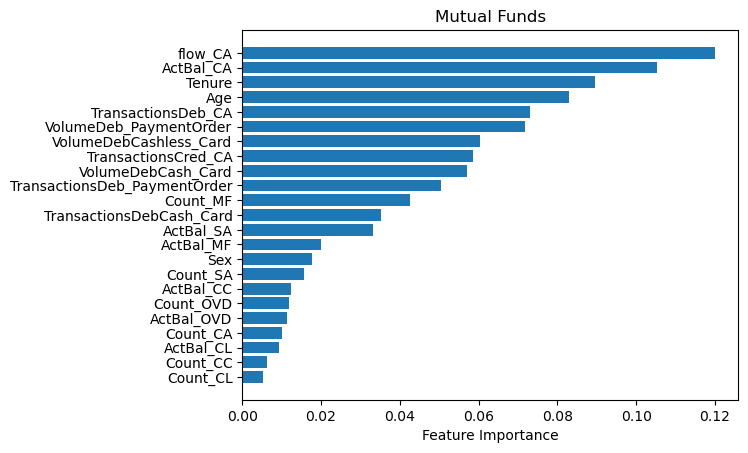

In [258]:
plt.title('Mutual Funds')
plt.barh(range(len(mf_indices)), mf_feature_importances[mf_indices], align = 'center')
plt.yticks(range(len(mf_indices)), [all_features[i] for i in mf_indices], rotation = 0)
plt.xlabel('Feature Importance')
plt.show()

Select the best set of MF features according to RF with 5-fold Cross-Validation

In [259]:
rfe_mf = RFECV(rfmf, cv = 5, scoring = "neg_mean_squared_error")
rfe_mf.fit(dmo_train_norm[all_features], dmo_train_norm[["Sale_MF"]].to_numpy().ravel())

RFECV(cv=5, estimator=RandomForestClassifier(n_estimators=500, random_state=50),
      scoring='neg_mean_squared_error')

In [260]:
mf_selected_features = np.array(all_features)[rfe_mf.get_support()]
mf_selected_features

array(['Age', 'Tenure', 'Count_MF', 'ActBal_CA', 'ActBal_SA', 'flow_CA',
       'TransactionsCred_CA', 'VolumeDebCash_Card',
       'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',
       'TransactionsDeb_CA', 'TransactionsDeb_PaymentOrder'], dtype='<U28')

#### Feature importances for CC

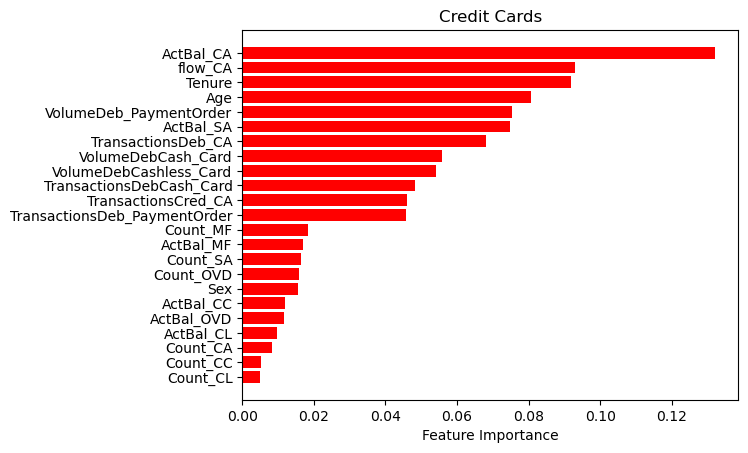

In [109]:
plt.title('Credit Cards')
plt.barh(range(len(cc_indices)), cc_feature_importances[cc_indices], color = "red", align = 'center')
plt.yticks(range(len(cc_indices)), [all_features[i] for i in cc_indices], rotation = 0)
plt.xlabel('Feature Importance')
plt.show()

Select the best set of CC features according to RF with 5-fold Cross-Validation

In [114]:
rfe_cc = RFECV(rfcc, cv = 5, scoring = "neg_mean_squared_error")
rfe_cc.fit(dmo_train_norm[all_features], dmo_train_norm[["Sale_CC"]].to_numpy().ravel())

RFECV(cv=5, estimator=RandomForestClassifier(n_estimators=500, random_state=50),
      scoring='neg_mean_squared_error')

In [115]:
cc_selected_features = np.array(all_features)[rfe_cc.get_support()]
cc_selected_features

array(['Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD',
       'ActBal_CC', 'ActBal_CL', 'flow_CA', 'TransactionsCred_CA',
       'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDeb_PaymentOrder'],
      dtype='<U28')

#### Feature importances for CL

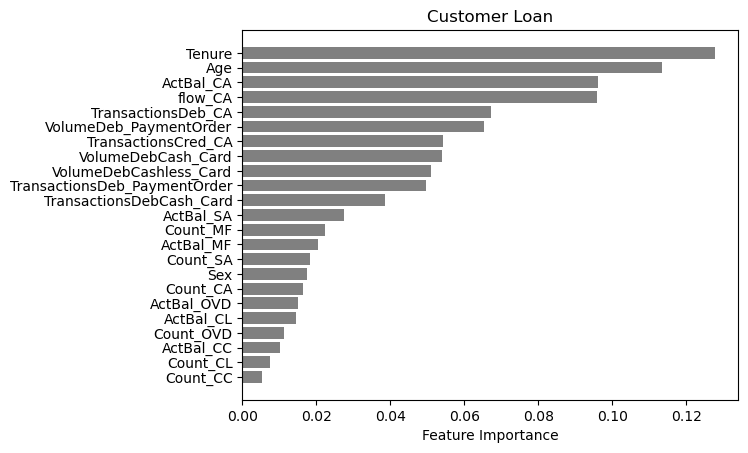

In [108]:
plt.title('Customer Loan')
plt.barh(range(len(cl_indices)), cl_feature_importances[cl_indices], color = "grey", align = 'center')
plt.yticks(range(len(cl_indices)), [all_features[i] for i in cl_indices], rotation = 0)
plt.xlabel('Feature Importance')
plt.show()

Select the best set of CL features according to RF with 5-fold Cross-Validation

In [116]:
rfe_cl = RFECV(rfcl, cv = 5, scoring = "neg_mean_squared_error")
rfe_cl.fit(dmo_train_norm[all_features], dmo_train_norm[["Sale_CL"]].to_numpy().ravel())

RFECV(cv=5, estimator=RandomForestClassifier(n_estimators=500, random_state=50),
      scoring='neg_mean_squared_error')

In [117]:
cl_selected_features = np.array(all_features)[rfe_cl.get_support()]
cl_selected_features

array(['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'flow_CA',
       'TransactionsCred_CA', 'VolumeDebCash_Card',
       'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',
       'TransactionsDeb_CA', 'TransactionsDebCash_Card',
       'TransactionsDeb_PaymentOrder'], dtype='<U28')

The RF feature selection procedure results in different features selected for predicting each target sale variable.

#### Training datasets for three propensity models

In [261]:
dmo_train_mf = dmo_train_norm[['Sale_MF'] + list(mf_selected_features)]
dmo_train_cc = dmo_train_norm[['Sale_CC'] + list(cc_selected_features)]
dmo_train_cl = dmo_train_norm[['Sale_CL'] + list(cl_selected_features)]

In [262]:
dmo_train_mf.head()

,Sale_MF,Age,Tenure,Count_MF,ActBal_CA,ActBal_SA,flow_CA,TransactionsCred_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDeb_PaymentOrder
0,1.0,51,7,0.0,0.017799,0.000000,0.397446,23.0,0.010606,0.077823,0.003997,30.0,9.0
1,0.0,43,152,0.0,0.001478,0.034180,0.401192,3.0,0.013030,0.010558,0.000576,6.0,1.0
4,0.0,24,19,0.0,0.000057,0.000000,0.397845,2.0,0.015152,0.000000,0.000000,6.0,0.0
6,0.0,64,30,0.0,0.000000,0.000000,0.397675,21.0,0.010758,0.001919,0.000000,24.0,0.0
11,0.0,66,132,0.0,0.004722,0.000015,0.396935,3.0,0.014394,0.047677,0.005045,39.0,10.0


### 3. Class imbalance

#### Check if the data is balanced

In [263]:
dmo_train_mf.Sale_MF.value_counts()

0.0    723
1.0    182
Name: Sale_MF, dtype: int64

In [264]:
dmo_train_cc.Sale_CC.value_counts()

0.0    674
1.0    231
Name: Sale_CC, dtype: int64

In [265]:
dmo_train_cl.Sale_CL.value_counts()

0.0    647
1.0    258
Name: Sale_CL, dtype: int64

The data are highly imbalanced: there are more clients who did not buy products compared to those who did. Downsampling is used to deal with the problem.

#### Downsampling

In [148]:
# Subset the client who buy the products
dmo_train_mf_sale_yes = dmo_train_mf.loc[dmo_train_mf['Sale_MF'] == 1]
dmo_train_cc_sale_yes = dmo_train_cc.loc[dmo_train_cc['Sale_CC'] == 1]
dmo_train_cl_sale_yes = dmo_train_cl.loc[dmo_train_cl['Sale_CL'] == 1]

# Sample the clients who did not buy any product (the size is equal to ds with the clients with sales)
dmo_train_mf_sale_no = dmo_train_mf.loc[dmo_train_mf['Sale_MF'] == 0].sample(len(dmo_train_mf_sale_yes),
                                                                             random_state = 10)
dmo_train_cc_sale_no = dmo_train_cc.loc[dmo_train_cc['Sale_CC'] == 0].sample(len(dmo_train_cc_sale_yes),
                                                                            random_state = 10)
dmo_train_cl_sale_no = dmo_train_cl.loc[dmo_train_cl['Sale_CL'] == 0].sample(len(dmo_train_cl_sale_yes),
                                                                             random_state = 10)

# Concatenate the dataframes

dmo_train_mf = pd.concat([dmo_train_mf_sale_yes, dmo_train_mf_sale_no])
dmo_train_cc = pd.concat([dmo_train_cc_sale_yes, dmo_train_cc_sale_no])
dmo_train_cl = pd.concat([dmo_train_cl_sale_yes, dmo_train_cl_sale_no])

#### Results after downsampling

In [149]:
dmo_train_mf.Sale_MF.value_counts()

1.0    182
0.0    182
Name: Sale_MF, dtype: int64

In [150]:
dmo_train_cc.Sale_CC.value_counts()

1.0    231
0.0    231
Name: Sale_CC, dtype: int64

In [151]:
dmo_train_cl.Sale_CL.value_counts()

1.0    258
0.0    258
Name: Sale_CL, dtype: int64

#### Stratify to ensure same distribution of both classes in training and validation

##### Split training datasets for training and validation - Full dataset (no downsampling)

In [266]:
X_mf_f, X_cc_f, X_cl_f = dmo_train_norm[mf_selected_features], dmo_train_norm[cc_selected_features], dmo_train_norm[cl_selected_features]
Y_mf_f, Y_cc_f, Y_cl_f = dmo_train_norm['Sale_MF'], dmo_train_norm['Sale_CC'], dmo_train_norm['Sale_CL']

X_trainmf_f, X_valmf_f, Y_trainmf_f, Y_valmf_f = train_test_split(X_mf_f, Y_mf_f, test_size = 0.2, 
                                                                  random_state = 20, stratify = Y_mf_f)
X_traincc_f, X_valcc_f, Y_traincc_f, Y_valcc_f = train_test_split(X_cc_f, Y_cc_f, test_size = 0.2, 
                                                                  random_state = 20, stratify = Y_cc_f)
X_traincl_f, X_valcl_f, Y_traincl_f, Y_valcl_f = train_test_split(X_cl_f, Y_cl_f, test_size = 0.2, 
                                                                  random_state = 20, stratify=Y_cl_f)

##### Split training datasets for training and validation - Downsampled dataset

In [ ]:
X_mf, X_cc, X_cl = dmo_train_mf[mf_selected_features], dmo_train_cc[cc_selected_features], dmo_train_cl[cl_selected_features]
Y_mf, Y_cc, Y_cl = dmo_train_mf['Sale_MF'], dmo_train_cc['Sale_CC'], dmo_train_cl['Sale_CL']

X_trainmf, X_valmf, Y_trainmf, Y_valmf = train_test_split(X_mf, Y_mf, test_size=0.2, random_state = 20, stratify=Y_mf)
X_traincc, X_valcc, Y_traincc, Y_valcc = train_test_split(X_cc, Y_cc, test_size=0.2, random_state = 20, stratify=Y_cc)
X_traincl, X_valcl, Y_traincl, Y_valcl = train_test_split(X_cl, Y_cl, test_size=0.2, random_state = 20, stratify=Y_cl)

### 4. Propensity Models¶

There is a classififcation problem: buyer vs non-buyer.

The propensity scores are most often estimated by logistic regression. However, the Neural networks, NN, have been noted as promising for propensity score estimation because they algorithmically handle nonlinear relationships and interactions. Here, the NN with one hidden layer, adam optimizer and binary crossentropy loss function is used. 
Using a sigmoid functon, the probability is predicted in the output layer. Root Mean Squared Error, RMSE, is used as a metric which judges the model performance on training and validation tests.

The model was applied to the imbalanced and ownsampled data sets.

The Area under the ROC Curve, AUC, is used to asses if the prediciton is good.

In [156]:
np.random.seed(42)

In [310]:
def create_nn(X_data, nodes1, nodes2):
    # Input layer
    inputs = keras.layers.Input(shape=(X_data.shape[1],), name='input')

    # Dense layers
    layers_dense = keras.layers.Dense(nodes1, 'relu')(inputs)
    # layers_dense = keras.layers.Dense(nodes2, 'relu')(layers_dense)

    # Output layer
    outputs = keras.layers.Dense(1, 'sigmoid')(layers_dense)

    return keras.Model(inputs=inputs, outputs=outputs, name="nn_model")

In [311]:
def train_validate_nn_model(X_train, Y_train, X_val, Y_val, nodes1 = 5, nodes2 = 10):
    
    model = create_nn(X_train, nodes1, nodes2)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.RootMeanSquaredError()])
    early_stopping_monitor = EarlyStopping(patience=50)
    history = model.fit(X_train, Y_train,
                    batch_size=32,
                    epochs=500,
                    validation_data=(X_val, Y_val),
                    verbose=False,
                    callbacks=[early_stopping_monitor])
    history_df = pd.DataFrame.from_dict(history.history)
    
    sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
    plt.xlabel("epochs")
    plt.ylabel("RMSE")
    
    return model

#### 4.1. Mutual Fund

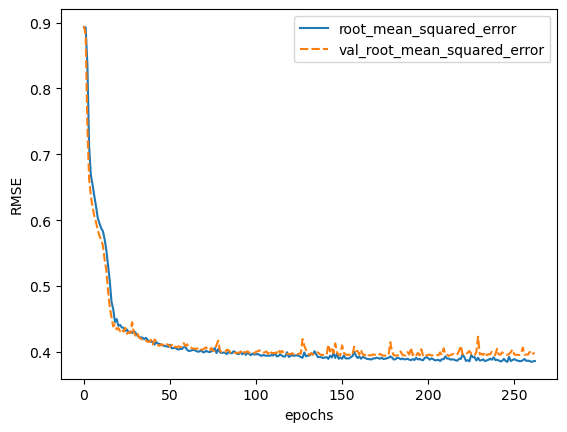

In [326]:
# Training and validation - Full dataset
sale_mf_f = train_validate_nn_model(X_trainmf_f, Y_trainmf_f, X_valmf_f, Y_valmf_f, 10)

In [327]:
# AUC Score - Full dataset
roc_auc_score(Y_valmf_f, sale_mf_f.predict(X_valmf_f))

6/6 [==============================] - 0s 903us/step


0.5557471264367816

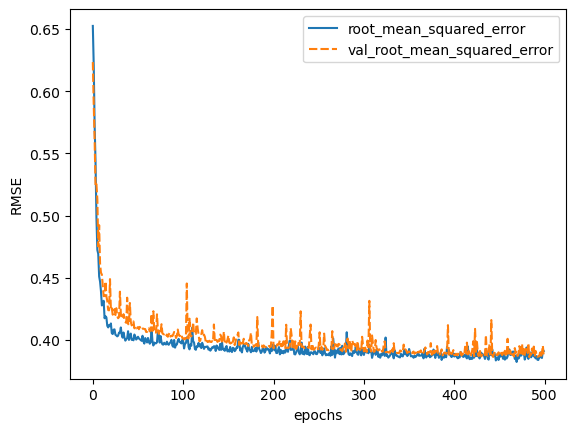

In [328]:
# Training and validation - Balanced dataset
sale_mf = train_validate_nn_model(X_trainmf, Y_trainmf, X_valmf, Y_valmf, 10)

In [329]:
# AUC Score - Balanced dataset
roc_auc_score(Y_valmf, sale_mf.predict(X_valmf))

6/6 [==============================] - 0s 889us/step


0.5634099616858238

The MF propensity modelling performed on the balanced and full datasets gives almost the same MRSE and AUC score. The balanced dataset migt be too small to improve modelling performance.

#### 4.2. Credit Cards

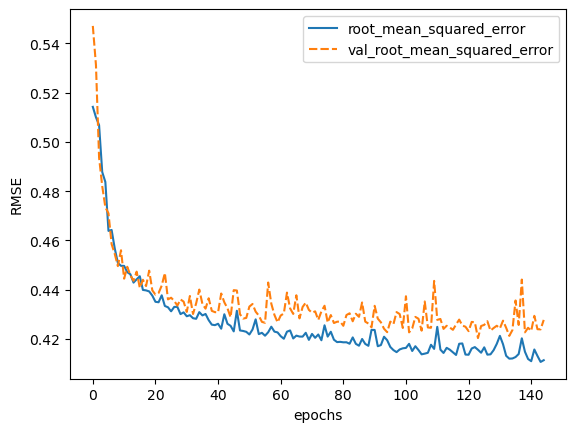

In [318]:
# Training and validation - Full dataset
sale_cc_f = train_validate_nn_model(X_traincc_f, Y_traincc_f, X_valcc_f, Y_valcc_f, 10)

In [319]:
# AUC Score - Full dataset
roc_auc_score(Y_valcc_f, sale_cc_f.predict(X_valcc_f))

6/6 [==============================] - 0s 1ms/step


0.6753623188405797

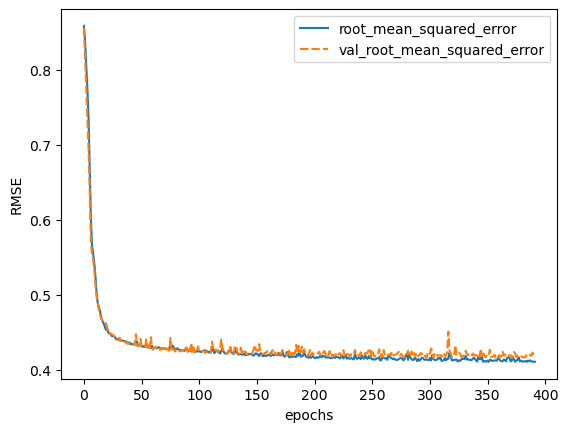

In [322]:
# Training and validation - Balanced dataset
sale_cc = train_validate_nn_model(X_traincc, Y_traincc, X_valcc, Y_valcc, 5)

In [323]:
# AUC Score - Balanced dataset
roc_auc_score(Y_valcc, sale_cc.predict(X_valcc))

6/6 [==============================] - 0s 969us/step


0.6735909822866345

The CC propensity modelling performed on the balanced and full datasets gives almost the same MRSE and AUC score. The balanced dataset migt be too small to improve modelling performance.

#### 4.3. Consumer Loan

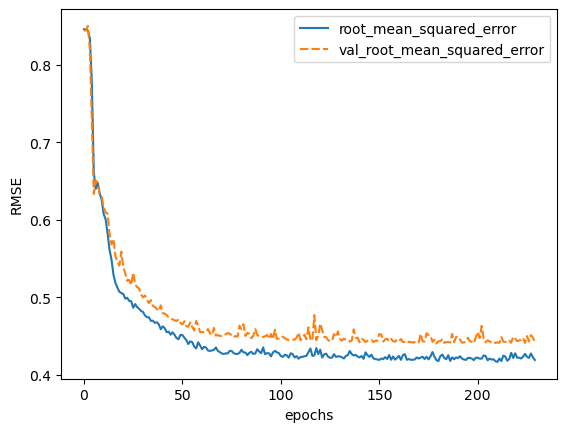

In [338]:
# Training and validation - Full dataset
sale_cl_f = train_validate_nn_model(X_traincl_f, Y_traincl_f, X_valcl_f, Y_valcl_f, 8)

In [339]:
# AUC Score - Full dataset
roc_auc_score(Y_valcl_f, sale_cl_f.predict(X_valcl_f))

6/6 [==============================] - 0s 1ms/step


0.6161299940369708

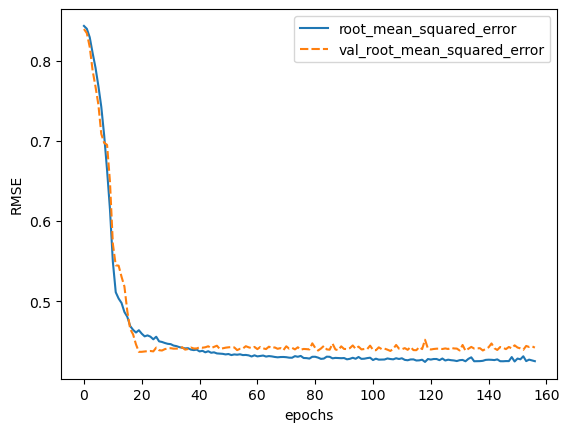

In [343]:
# Training and validation - Balanced dataset
sale_cl = train_validate_nn_model(X_traincl, Y_traincl, X_valcl, Y_valcl, 5)

In [344]:
# AUC Score - Balanced dataset
roc_auc_score(Y_valcl, sale_cl.predict(X_valcl))

6/6 [==============================] - 0s 933us/step


0.6346153846153846

The Consumer Loan (CL) propensity modelling performed on balanced dataset gives a better accuracy and AUC score than the full dataset. 

### 5. Propensity Prediction on Test Set

#### Test Data preparation

In [270]:
features_to_normalize = ['flow_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
                         'VolumeDeb_PaymentOrder', 'ActBal_CA', 'ActBal_SA',
                         'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']

min_max_scaler = preprocessing.MinMaxScaler()
dmo_test_norm = min_max_scaler.fit_transform(dmo_test[features_to_normalize])
dmo_test_norm = pd.DataFrame(dmo_test_norm, columns=features_to_normalize, 
                              index=dmo_test[features_to_normalize].index)

dmo_test_norm = pd.concat((dmo_test.drop(columns = features_to_normalize),
                           dmo_test_norm), 
                           axis = 1)

dmo_test_norm.describe()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,TransactionsCred_CA,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,flow_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,0.0,0.0,0.0,0.0,0.0,0.0,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,799.351082,0.527454,45.038270,103.469218,1.088186,0.277870,0.672213,0.256240,0.093178,0.116473,4.129784,13.154742,1.983361,4.600666,NaN,NaN,NaN,NaN,NaN,NaN,0.395374,0.025241,0.055348,0.009884,0.013536,0.018293,0.005295,0.019345,0.013326,0.020300
std,469.013036,0.502986,16.851316,63.715588,0.356665,0.536339,2.101756,0.436919,0.290924,0.427876,4.918312,13.046367,2.747676,5.246929,NaN,NaN,NaN,NaN,NaN,NaN,0.038733,0.056871,0.112308,0.047763,0.048460,0.079392,0.050738,0.094061,0.068949,0.092447
min,4.000000,-1.000000,19.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,381.000000,0.000000,31.000000,48.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.391715,0.000000,0.000000,0.000000,0.000250,0.000000,0.000000,0.000000,0.000000,0.000000
50%,796.000000,1.000000,42.000000,102.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,10.000000,1.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.393141,0.007353,0.003587,0.002362,0.002056,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1204.000000,1.000000,58.000000,152.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.000000,19.000000,3.000000,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.394667,0.034926,0.059654,0.007221,0.011210,0.000000,0.000000,0.000000,0.000000,0.000000
max,1614.000000,1.000000,97.000000,273.000000,4.000000,5.000000,28.000000,1.000000,1.000000,5.000000,37.000000,72.000000,17.000000,31.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Prediction of the Sale_MF, Sale_CC and Sale_CL probabilities for the test set

In [354]:
dmo_test_norm.loc[:, 'Sale_MF'] = sale_mf.predict(dmo_test_norm[mf_selected_features])
dmo_test_norm.loc[:, 'Sale_CC'] = sale_cc.predict(dmo_test_norm[cc_selected_features])
dmo_test_norm.loc[:, 'Sale_CL'] = sale_cl.predict(dmo_test_norm[cl_selected_features])
dmo_test_norm

19/19 [==============================] - 0s 717us/step


,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,TransactionsCred_CA,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,flow_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
2,4,1,24,153,1,1.0,0.0,0.0,1.0,0.0,4.0,36.0,6.0,13.0,0.150057,0.171359,0.740305,8.646342,6.154908,11.43025,0.367526,0.073529,0.212942,0.027161,9.324391e-03,0.000348,0.0,0.000000,0.315249,0.000000
3,5,0,58,200,1,1.0,0.0,0.0,0.0,0.0,14.0,41.0,4.0,13.0,0.224485,0.275904,0.266802,8.646342,6.154908,11.43025,0.377746,0.016176,0.336867,0.024621,3.120184e-02,0.036832,0.0,0.000000,0.000000,0.000000
5,7,0,55,227,1,0.0,0.0,0.0,0.0,0.0,2.0,10.0,1.0,1.0,0.201389,0.193448,0.338958,8.646342,6.154908,11.43025,0.397301,0.001838,0.027993,0.000148,5.127090e-03,0.000000,0.0,0.000000,0.000000,0.000000
7,9,0,33,182,1,0.0,0.0,1.0,0.0,0.0,4.0,7.0,1.0,3.0,0.232140,0.267831,0.540957,8.646342,6.154908,11.43025,0.393200,0.005515,0.000000,0.002362,2.973416e-03,0.000000,0.0,0.000000,0.000000,0.000000
8,10,0,29,48,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.225836,0.252845,0.228612,8.646342,6.154908,11.43025,0.393128,0.000000,0.000000,0.000000,1.477241e-03,0.000532,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,1606,1,47,78,1,0.0,0.0,0.0,0.0,1.0,5.0,17.0,0.0,5.0,0.258374,0.192580,0.212440,8.646342,6.154908,11.43025,0.403891,0.000000,0.052348,0.003039,1.379318e-02,0.000000,0.0,0.000000,0.000000,0.013022
1500,1609,1,31,111,1,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,0.208594,0.214679,0.287164,8.646342,6.154908,11.43025,0.392883,0.000000,0.000000,0.001286,1.205718e-03,0.000000,0.0,0.000000,0.000000,0.000000
1501,1610,0,48,92,1,0.0,0.0,1.0,0.0,0.0,5.0,18.0,3.0,7.0,0.241402,0.209409,0.219052,8.646342,6.154908,11.43025,0.488702,0.020221,0.017767,0.002343,1.145524e-03,0.000000,0.0,0.335006,0.000000,0.000000
1502,1611,0,41,181,1,0.0,0.0,1.0,0.0,0.0,3.0,11.0,1.0,6.0,0.187264,0.273498,0.433356,8.646342,6.154908,11.43025,0.392063,0.018382,0.013012,0.012321,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000


### 6. Revenue

The goal is to investigate the potential revenue generated by a marketing campaign targeting clients with high propensity.

The mean of each revenue type (MF, CC, CL) was used as target revenue for a client buying the corresponding product type.

#### EDA for revenue data

<AxesSubplot:>

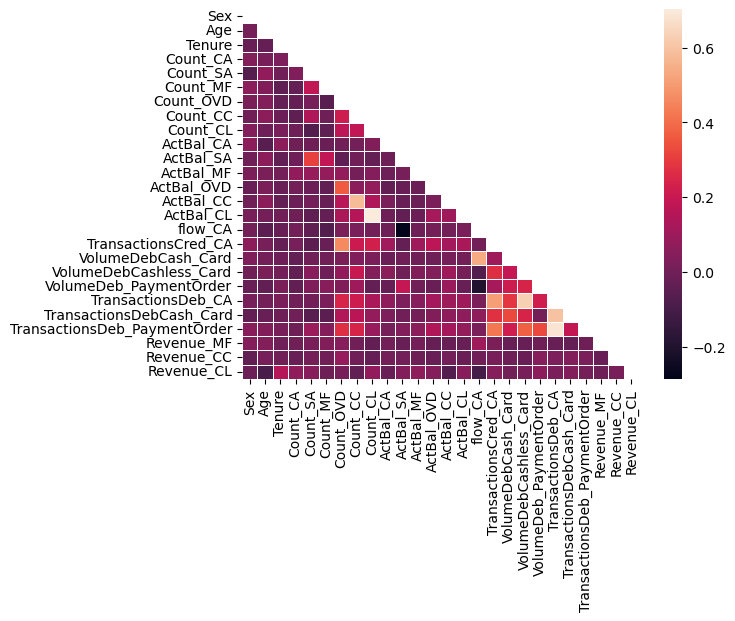

In [272]:
dmo_cor = dmo_train[soc_dem + products_act_bal + inflow_outflow + revenue].corr()

mask = np.triu(np.ones_like(dmo_cor))

sns.heatmap(dmo_cor, annot=False, linewidth=.5, mask=mask, xticklabels=True, yticklabels=True)

The revenue features don't correlate strongly with any features.

#### Outlier detection

Remove Revenues with zeroes

In [273]:
revenue_mf = dmo_train['Revenue_MF'][dmo_train['Revenue_MF']>0]
revenue_cc = dmo_train['Revenue_CC'][dmo_train['Revenue_CC']>0]
revenue_cl = dmo_train['Revenue_CL'][dmo_train['Revenue_CL']>0]

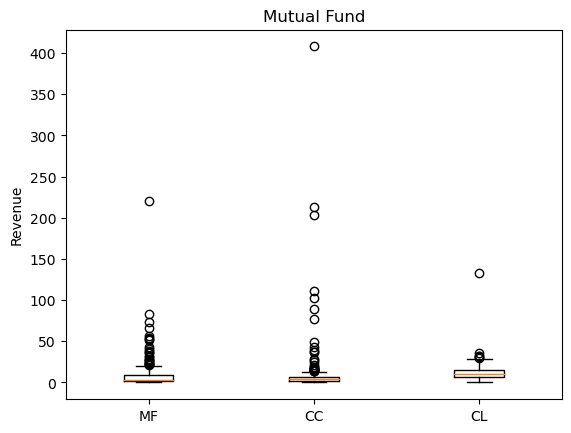

In [274]:
plt.boxplot([revenue_mf, revenue_cc, revenue_cl], labels = ["MF", "CC", "CL"])
plt.title("Mutual Fund")
plt.ylabel('Revenue')
plt.show()

#### Remove outlier

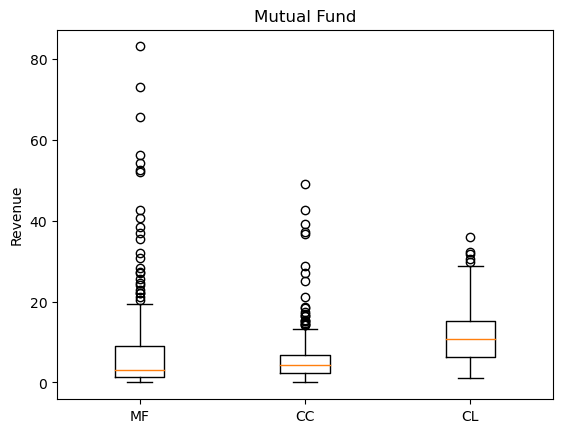

In [275]:
revenue_mf = revenue_mf[revenue_mf < 100]
revenue_cc = revenue_cc[revenue_cc < 50]
revenue_cl = revenue_cl[revenue_cl < 100]

plt.boxplot([revenue_mf, revenue_cc, revenue_cl], labels = ["MF", "CC", "CL"])
plt.title("Mutual Fund")
plt.ylabel('Revenue')
plt.show()

#### Revenue values for test data

In [276]:
[revenue_mf.mean(), revenue_cc.mean(), revenue_cl.mean()]

[8.646341752170482, 6.154907525510203, 11.430250138966093]

In [277]:
dmo_test_norm.loc[:, 'Revenue_MF'] = revenue_mf.mean()
dmo_test_norm.loc[:, 'Revenue_CC'] = revenue_cc.mean()
dmo_test_norm.loc[:, 'Revenue_CL'] = revenue_cl.mean()

final_features = ['Client', 'Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL']

final_df = dmo_test_norm[final_features]
final_df


,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
2,4,0.231984,0.475996,0.866184,8.646342,6.154908,11.43025
3,5,0.266429,0.495209,0.611468,8.646342,6.154908,11.43025
5,7,0.188891,0.478742,0.329082,8.646342,6.154908,11.43025
7,9,0.235294,0.559704,0.757102,8.646342,6.154908,11.43025
8,10,0.212443,0.455708,0.369513,8.646342,6.154908,11.43025
...,...,...,...,...,...,...,...
1497,1606,0.153114,0.481940,0.330447,8.646342,6.154908,11.43025
1500,1609,0.278311,0.422702,0.375327,8.646342,6.154908,11.43025
1501,1610,0.133486,0.481679,0.385522,8.646342,6.154908,11.43025
1502,1611,0.221508,0.478229,0.630053,8.646342,6.154908,11.43025


### 7. Results

#### 7.1. Which clients have higher propensity to buy consumer loan?

In [346]:
# Sort the output_data by Sale_CL in descending order
final_df = final_df.sort_values('Sale_CL', ascending = False)

# Save clients' propensity to buy a CL to csv 
final_df[['Client', 'Sale_CL']].to_csv('../results/01_propensity_to_cl.csv', sep=';', header = True, index = False)
final_df.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Score_MF,Score_CC,Score_CL,Expected_Revenue,Best_Offer
648,697,0.585972,0.335342,0.994161,8.646342,6.154908,11.43025,5.066511,2.063996,11.363508,11.363508,Consumer Loan
543,583,0.582502,0.372735,0.972856,8.646342,6.154908,11.43025,5.036515,2.294147,11.119989,11.119989,Consumer Loan
628,674,0.389913,0.638622,0.953962,8.646342,6.154908,11.43025,3.371324,3.930659,10.904027,10.904027,Consumer Loan
1362,1458,0.372590,0.526846,0.948212,8.646342,6.154908,11.43025,3.221538,3.242691,10.838304,10.838304,Consumer Loan
53,57,0.505729,0.492897,0.941082,8.646342,6.154908,11.43025,4.372704,3.033736,10.756805,10.756805,Consumer Loan


##### Important features for determining their propensity:

In [282]:
print(cl_selected_features)

['Age' 'Tenure' 'ActBal_CA' 'ActBal_SA' 'ActBal_MF' 'flow_CA'
 'TransactionsCred_CA' 'VolumeDebCash_Card' 'VolumeDebCashless_Card'
 'VolumeDeb_PaymentOrder' 'TransactionsDeb_CA' 'TransactionsDebCash_Card'
 'TransactionsDeb_PaymentOrder']


#### 7.2. Which clients have higher propensity to buy credit card?

In [347]:
# Sort the output_data by Sale_CL in descending order
final_df = final_df.sort_values('Sale_CC', ascending = False)

# Save clients' propensity to buy a CL to csv 
final_df[['Client', 'Sale_CC']].to_csv('../results/02_propensity_to_cc.csv', sep = ';', header = True, index = False)
final_df.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Score_MF,Score_CC,Score_CL,Expected_Revenue,Best_Offer
141,150,0.212924,0.957241,0.665229,8.646342,6.154908,11.43025,1.841017,5.891731,7.603731,7.603731,Consumer Loan
1281,1373,0.347074,0.910671,0.394876,8.646342,6.154908,11.43025,3.000924,5.605094,4.513536,5.605094,Credit Card
806,866,0.334813,0.853340,0.830827,8.646342,6.154908,11.43025,2.894908,5.252232,9.496560,9.496560,Consumer Loan
1002,1077,0.215474,0.828844,0.805427,8.646342,6.154908,11.43025,1.863066,5.101458,9.206227,9.206227,Consumer Loan
403,431,0.285582,0.823319,0.671222,8.646342,6.154908,11.43025,2.469242,5.067451,7.672236,7.672236,Consumer Loan


##### Important features for determining their propensity:

In [282]:
print(cl_selected_features)

['Age' 'Tenure' 'ActBal_CA' 'ActBal_SA' 'ActBal_MF' 'flow_CA'
 'TransactionsCred_CA' 'VolumeDebCash_Card' 'VolumeDebCashless_Card'
 'VolumeDeb_PaymentOrder' 'TransactionsDeb_CA' 'TransactionsDebCash_Card'
 'TransactionsDeb_PaymentOrder']


#### 7.3. Which clients have higher propensity to buy mutual fund?

In [348]:
# Sort the output_data by Sale_CL in descending order
final_df = final_df.sort_values('Sale_MF', ascending = False)

# Save clients' propensity to buy a CL to csv 
final_df[['Client', 'Sale_MF']].to_csv('../results/03_propensity_to_mf.csv', sep = ';', header = True, index = False)
final_df.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Score_MF,Score_CC,Score_CL,Expected_Revenue,Best_Offer
365,389,0.818270,0.533837,0.357089,8.646342,6.154908,11.43025,7.075040,3.285718,4.081622,7.075040,Mutual Fund
704,756,0.808112,0.418207,0.931977,8.646342,6.154908,11.43025,6.987213,2.574023,10.652733,10.652733,Consumer Loan
1042,1119,0.780469,0.451645,0.894004,8.646342,6.154908,11.43025,6.748198,2.779836,10.218693,10.218693,Consumer Loan
725,779,0.774160,0.528347,0.583120,8.646342,6.154908,11.43025,6.693655,3.251930,6.665211,6.693655,Mutual Fund
623,668,0.666573,0.606602,0.597564,8.646342,6.154908,11.43025,5.763414,3.733579,6.830307,6.830307,Consumer Loan


##### Important features for determining their propensity:

In [287]:
print(mf_selected_features)

['Age' 'Tenure' 'Count_MF' 'ActBal_CA' 'ActBal_SA' 'flow_CA'
 'TransactionsCred_CA' 'VolumeDebCash_Card' 'VolumeDebCashless_Card'
 'VolumeDeb_PaymentOrder' 'TransactionsDeb_CA'
 'TransactionsDeb_PaymentOrder']


#### 7.4. Which clients are to be targeted with which offer?

The hypothesis is following: The higher revenue is generated from the clients with the higher propensity.

An expected revenue for each client per product is calculated by mutliplying the propensity and mean revenue. The highest expected revenue among the three products is chosen as a best offer for each client. The top 100 customers with the highest revenue should be targeted.

In [355]:
final_df.loc[:, 'Score_MF'] = final_df.loc[:, 'Sale_MF'] * final_df.loc[:, 'Revenue_MF']
final_df.loc[:, 'Score_CC'] = final_df.loc[:, 'Sale_CC'] * final_df.loc[:, 'Revenue_CC']
final_df.loc[:, 'Score_CL'] = final_df.loc[:, 'Sale_CL'] * final_df.loc[:, 'Revenue_CL']

final_df

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Score_MF,Score_CC,Score_CL,Expected_Revenue,Best_Offer
648,697,0.585972,0.335342,0.994161,8.646342,6.154908,11.43025,5.066511,2.063996,11.363508,11.363508,Consumer Loan
543,583,0.582502,0.372735,0.972856,8.646342,6.154908,11.43025,5.036515,2.294147,11.119989,11.119989,Consumer Loan
628,674,0.389913,0.638622,0.953962,8.646342,6.154908,11.43025,3.371324,3.930659,10.904027,10.904027,Consumer Loan
1362,1458,0.372590,0.526846,0.948212,8.646342,6.154908,11.43025,3.221538,3.242691,10.838304,10.838304,Consumer Loan
53,57,0.505729,0.492897,0.941082,8.646342,6.154908,11.43025,4.372704,3.033736,10.756805,10.756805,Consumer Loan
...,...,...,...,...,...,...,...,...,...,...,...,...
642,690,0.246751,0.496110,0.244468,8.646342,6.154908,11.43025,2.133495,3.053513,2.794334,3.053513,Credit Card
779,835,0.262126,0.489585,0.265885,8.646342,6.154908,11.43025,2.266429,3.013348,3.039127,3.039127,Consumer Loan
432,463,0.227721,0.485504,0.263184,8.646342,6.154908,11.43025,1.968951,2.988235,3.008264,3.008264,Consumer Loan
504,541,0.335792,0.401598,0.227133,8.646342,6.154908,11.43025,2.903369,2.471797,2.596191,2.903369,Mutual Fund


In [356]:
def compare(client):
    if client['Score_MF'] > client['Score_CC'] and client['Score_MF'] > client['Score_CL']:   # MF
        result = [client['Score_MF'], 'Mutual Fund']
    elif client['Score_CC'] > client['Score_MF'] and client['Score_CC'] > client['Score_CL']: # CC
        result = [client['Score_CC'], 'Credit Card']
    elif client['Score_CL'] > client['Score_MF'] and client['Score_CL'] > client['Score_CC']: # CL
        result = [client['Score_CL'], 'Consumer Loan']
    return result

final_df.loc[:, 'Expected_Revenue'] = final_df.apply(lambda client:compare(client)[0], axis = 1)
final_df.loc[:, 'Best_Offer'] = final_df.apply(lambda client:compare(client)[1], axis = 1)
final_df

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Score_MF,Score_CC,Score_CL,Expected_Revenue,Best_Offer
648,697,0.585972,0.335342,0.994161,8.646342,6.154908,11.43025,5.066511,2.063996,11.363508,11.363508,Consumer Loan
543,583,0.582502,0.372735,0.972856,8.646342,6.154908,11.43025,5.036515,2.294147,11.119989,11.119989,Consumer Loan
628,674,0.389913,0.638622,0.953962,8.646342,6.154908,11.43025,3.371324,3.930659,10.904027,10.904027,Consumer Loan
1362,1458,0.372590,0.526846,0.948212,8.646342,6.154908,11.43025,3.221538,3.242691,10.838304,10.838304,Consumer Loan
53,57,0.505729,0.492897,0.941082,8.646342,6.154908,11.43025,4.372704,3.033736,10.756805,10.756805,Consumer Loan
...,...,...,...,...,...,...,...,...,...,...,...,...
642,690,0.246751,0.496110,0.244468,8.646342,6.154908,11.43025,2.133495,3.053513,2.794334,3.053513,Credit Card
779,835,0.262126,0.489585,0.265885,8.646342,6.154908,11.43025,2.266429,3.013348,3.039127,3.039127,Consumer Loan
432,463,0.227721,0.485504,0.263184,8.646342,6.154908,11.43025,1.968951,2.988235,3.008264,3.008264,Consumer Loan
504,541,0.335792,0.401598,0.227133,8.646342,6.154908,11.43025,2.903369,2.471797,2.596191,2.903369,Mutual Fund


In [357]:
final_df = final_df.sort_values('Expected_Revenue', ascending=False)
target_clients = final_df.loc[:,['Client', 'Expected_Revenue', 'Best_Offer']].head(100)
target_clients['Best_Offer'].value_counts()

Consumer Loan    100
Name: Best_Offer, dtype: int64

100 clients should to be targeted with Consumer Loan offer

In [352]:
# Save output to csv file
target_clients.to_csv('../results/04_target_clients.csv', sep=';', header=True, index=False)
target_clients

,Client,Expected_Revenue,Best_Offer
648,697,11.363508,Consumer Loan
543,583,11.119989,Consumer Loan
628,674,10.904027,Consumer Loan
1362,1458,10.838304,Consumer Loan
53,57,10.756805,Consumer Loan
...,...,...,...
349,373,7.718765,Consumer Loan
1251,1341,7.705815,Consumer Loan
64,70,7.689966,Consumer Loan
403,431,7.672236,Consumer Loan


#### 7.5. What would be the expected revenue?

In [358]:
target_clients['Expected_Revenue'].sum()

938.6886766456537

### Summary

The goal of the task was to maximise revenue from direct marketing campaigns with a limited number of clients to target with a specific product per client. The input data included social-demographical data, products and actual account volumes, inflow/outflow on C/A turnovers, and actual sales and revenues for 60% of clients.

First, the input data were combined into a single dataset (see 01_transform_ds.ipynb). The combined dataset dmo.csv is stored in the folder data. Then exploratory data analysis, EDA, was applied to the generated dataset (see 02_exploratory_data_analysis.ipynb). During EDA, imputation for missing values, feature reduction or transformation based on correlations and normalization were applied as a pre-processing step. The reduced dataset dmo_reduced.csv is stored in the folder data.

Then, the most important feature of each model was selected. For these purposes, Random Forests, RF, were used. RF was chosen because it can describe nonlinear relationships while retaining evidence of partial dependency. Penalised generalised linear models, such as LASSO regression, might capture the partial dependency, i.e. possibly skewed estimated coefficients, yet they can only represent linear relations. SVM can model nonlinear associations but cannot detect partial dependency. The best sets of Mutual Fund (MF), Credit Card (CC) and Consumer Loan (CL) features were selected according to RF with 5-fold Cross-Validation. This procedure results in different features selected for predicting each target sale variable. For the sets of features, see sections 7.1 - 7.3.

The data was highly imbalanced: more clients don't buy products compared to those who do. Downsampling was used to deal with the problem.

Although the propensity scores are most often estimated by logistic regression, the Neural networks, NN, have been noted as promising for propensity score estimation because they algorithmically handle nonlinear relationships and interactions. The keras NN with one hidden layer, adam optimizer and binary cross-entropy loss function was used to build MF, CC, CL propensity models. Using a sigmoid function, the probability was predicted as an output layer. Root Mean Squared Error, RMSE, was used as a metric which judged the model performance on training and validation tests. The model was applied to the imbalanced and downsampled data sets using the ML, CC, CL sets of important features. The Area under the ROC Curve, AUC, was used to assess if the prediction is good. The performance of all propensity models on the balanced and full datasets gave almost the same MRSE and AUC scores. The balanced dataset might have been too small to improve modelling performance. Across all models, the validation MRSE was ~ 40 and AUC scores were between 55 and 67.

The sales propensity for the test data was predicted using the generated NN models. After removing outliers, i.e. those clients who tended to deviate from the majority, the average revenue for each sale type from training data was then considered in the test data as the target revenue. The expected revenue for each client per product was calculated by multiplying the propensity and mean revenue. The highest expected revenue among the three products was considered the best offer for each client to maximise the total revenue. The top 100 customers with the highest revenue should be targeted. The top 100 clients were obtained by ranking on maximum expected revenue per client. The expected revenue with this strategy was **938.7**. The list of the top 100 clients which should be contacted is stored in the *results* folder: 04_target_clients.csv. The results folder also contains the followingdata:

- *01_propensity_to_cl.csv*: the list of clients who have a higher propensity to buy consumer - loan
- *02_propensity_to_cc.csv*: the list of clients who have a higher propensity to buy credit card
- *03_propensity_to_mf.csv*: the list of clients who have a higher propensity to buy a mutual fund